# Loading Libraries

In [122]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict,Counter
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

In [123]:
#Setting seed for reproducibility
np.random.seed(500)

# Reading in the dataset


In [124]:
df = pd.read_csv("hf://datasets/USC-MOLA-Lab/MFRC/final_mfrc_data.csv")
df.head()

,text,subreddit,bucket,annotator,annotation,confidence
0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident
1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident
2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident
3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident
4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident


# Descriptive Statistics

### Unique entry count

In [125]:
unique_count_entries = df['text'].nunique()
count_entries = df['text'].count()
print(f'There are a total of {count_entries} out of which there are only {unique_count_entries} that are unique which means each\
 row is repeated {count_entries/unique_count_entries:.2f} times')

There are a total of 61226 out of which there are only 17886 that are unique which means each row is repeated 3.42 times


### Identifying unique annotations

In [126]:
from pprint import pprint

annotations = list(df['annotation'].unique())
new_annotations = set([word for phrase in annotations for word in phrase.split(',')])
original_foundations = set(['Care','Harm',
                        'Fairness','Cheating',
                        'Loyalty','Betrayal',
                        'Authority','Subversion',
                        'Purity', 'Degradation'
                        ])
missing = new_annotations - original_foundations
print('Number of unique ethical frameworks: ',len(new_annotations))
print('The moral foundations are the following:\n',new_annotations)
print('The missing foundations are:',missing)


Number of unique ethical frameworks:  8
The moral foundations are the following:
 {'Care', 'Non-Moral', 'Proportionality', 'Purity', 'Thin Morality', 'Loyalty', 'Equality', 'Authority'}
The missing foundations are: {'Equality', 'Proportionality', 'Non-Moral', 'Thin Morality'}


### Counting Annotators


In [127]:
annotator_set = set([annotator for annotator in df['annotator']])
print(f'There are {len(annotator_set)} annotators. They are the following:\n{annotator_set}')

There are 6 annotators. They are the following:
{'annotator05', 'annotator00', 'annotator04', 'annotator03', 'annotator01', 'annotator02'}


### Identifying unique confidence levels

In [128]:
confidence_levels = set([confidence for confidence in df['confidence']])
print(f'There are {len(confidence_levels)} annotators. They are the following:\n{confidence_levels}')


confidence_weights = {
    'Not Confident' : 1,
    'Somewhat Confident' : 2,
    'Confident' : 4
}
confidence_weights

There are 4 annotators. They are the following:
{nan, 'Somewhat Confident', 'Not Confident', 'Confident'}


{'Not Confident': 1, 'Somewhat Confident': 2, 'Confident': 4}

### General Descriptive statistics

In [129]:
df.head(5)

,text,subreddit,bucket,annotator,annotation,confidence
0,That particular part of the debate is especial...,europe,French politics,annotator03,Non-Moral,Confident
1,That particular part of the debate is especial...,europe,French politics,annotator01,Purity,Confident
2,That particular part of the debate is especial...,europe,French politics,annotator02,Thin Morality,Confident
3,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator03,Non-Moral,Confident
4,"/r/france is pretty lively, with it's own ling...",europe,French politics,annotator00,Non-Moral,Somewhat Confident


In [130]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61226 entries, 0 to 61225
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        61226 non-null  object
 1   subreddit   61226 non-null  object
 2   bucket      61226 non-null  object
 3   annotator   61226 non-null  object
 4   annotation  61226 non-null  object
 5   confidence  61184 non-null  object
dtypes: object(6)
memory usage: 2.8+ MB
None


,text,subreddit,bucket,annotator,annotation,confidence
count,61226,61226,61226,61226,61226,61184
unique,17886,11,3,6,128,3
top,༼ つ ◕_◕ ༽つ MACRON TAKE MY ENERGY ༼ つ ◕_◕ ༽つ,europe,French politics,annotator04,Non-Moral,Confident
freq,11,9281,25079,11988,30770,44737


# Transforming the dataset: 

### Adding unique annotations as columns in the dataset 

In [131]:
labels = ['Purity', 'Loyalty', 'Care', 'Proportionality', 'Thin Morality', 'Authority', 'Equality', 'Non-Moral']
df1 = df.copy()
# Initialize the columns with zeros if not already present
for label in labels:
    if label not in df1.columns:
        df1[label] = 0


In [132]:
for row_num, row in enumerate(df['annotation']):
    annotations = [a.strip() for a in row.split(',')]
    for label in labels:
        if label in annotations:
            df1.at[row_num, label] += 1

### Adding effect of Confidence Weights to data

In [133]:
# Removing rows where confidence is null
df2 = df1.copy()
df2 = df2.loc[-df2['confidence'].isna() == True]

In [134]:
labels = ['Purity', 'Loyalty', 'Care', 'Proportionality', 'Thin Morality', 'Authority', 'Equality', 'Non-Moral']

# Map confidence values to weights as a Series -> Vectorizing the weights 
weights = df2.iloc[:, 5].map(confidence_weights)

# Apply weights to each column directly
for label in labels:
    df2[label] *= weights

In [135]:
# Creating dataframe to sum up annotator votes 
df3 = df2.groupby(['text','subreddit']).sum()
df3 = df3.reset_index(['text','subreddit']) #resetting index to make everything into a column
df3.head(5)

,text,subreddit,bucket,annotator,annotation,confidence,Purity,Loyalty,Care,Proportionality,Thin Morality,Authority,Equality,Non-Moral
0,"\n\nDr. Robert Jay Lifton, distinguished profe...",politics,US PoliticsUS PoliticsUS Politics,annotator04annotator00annotator02,AuthorityThin MoralityNon-Moral,ConfidentNot ConfidentConfident,0,0,0,0,1,4,0,4
1,\n\nIf you prefer not to click on Daily Mail s...,worldnews,French politicsFrench politicsFrench politicsF...,annotator01annotator00annotator02annotator02,Non-MoralNon-MoralNon-MoralNon-Moral,ConfidentConfidentConfidentConfident,0,0,0,0,0,0,0,16
2,\n&gt;Ben Judah details Emmanuel Macron's nasc...,geopolitics,French politicsFrench politicsFrench politicsF...,annotator04annotator01annotator00annotator01,ProportionalityAuthorityAuthorityAuthority,ConfidentConfidentNot ConfidentConfident,0,0,0,4,0,9,0,0
3,"\n&gt;Ergo, he supports Macron but doesn't wan...",neoliberal,French politicsFrench politicsFrench politics,annotator03annotator04annotator02,Thin MoralityLoyaltyNon-Moral,Somewhat ConfidentConfidentConfident,0,4,0,0,2,0,0,4
4,\n&gt;He looks exactly the same in Richie Rich...,nostalgia,Everyday MoralityEveryday MoralityEveryday Mor...,annotator03annotator04annotator02,Non-MoralThin MoralityNon-Moral,ConfidentConfidentConfident,0,0,0,0,4,0,0,8


In [136]:
labels = ['Purity', 'Loyalty', 'Care', 'Proportionality', 'Thin Morality', 'Authority', 'Equality', 'Non-Moral']

# Get the name of the column with the highest value across the specified columns
# first class with the highest vote based on which column comes first
df3['Moral Foundation'] = df3[labels].idxmax(axis=1)


In [137]:
df3.head()

,text,subreddit,bucket,annotator,annotation,confidence,Purity,Loyalty,Care,Proportionality,Thin Morality,Authority,Equality,Non-Moral,Moral Foundation
0,"\n\nDr. Robert Jay Lifton, distinguished profe...",politics,US PoliticsUS PoliticsUS Politics,annotator04annotator00annotator02,AuthorityThin MoralityNon-Moral,ConfidentNot ConfidentConfident,0,0,0,0,1,4,0,4,Authority
1,\n\nIf you prefer not to click on Daily Mail s...,worldnews,French politicsFrench politicsFrench politicsF...,annotator01annotator00annotator02annotator02,Non-MoralNon-MoralNon-MoralNon-Moral,ConfidentConfidentConfidentConfident,0,0,0,0,0,0,0,16,Non-Moral
2,\n&gt;Ben Judah details Emmanuel Macron's nasc...,geopolitics,French politicsFrench politicsFrench politicsF...,annotator04annotator01annotator00annotator01,ProportionalityAuthorityAuthorityAuthority,ConfidentConfidentNot ConfidentConfident,0,0,0,4,0,9,0,0,Authority
3,"\n&gt;Ergo, he supports Macron but doesn't wan...",neoliberal,French politicsFrench politicsFrench politics,annotator03annotator04annotator02,Thin MoralityLoyaltyNon-Moral,Somewhat ConfidentConfidentConfident,0,4,0,0,2,0,0,4,Loyalty
4,\n&gt;He looks exactly the same in Richie Rich...,nostalgia,Everyday MoralityEveryday MoralityEveryday Mor...,annotator03annotator04annotator02,Non-MoralThin MoralityNon-Moral,ConfidentConfidentConfident,0,0,0,0,4,0,0,8,Non-Moral


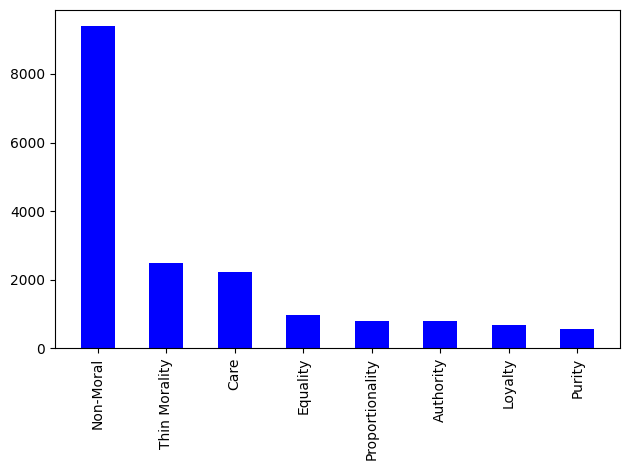

In [144]:
from matplotlib import pyplot as plt

a = dict(df3['Moral Foundation'].value_counts())
plt.bar(a.keys(), a.values(),width = 0.5, color='b')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [139]:
# Lower case sentences for easier identification by model
df3['text'] = [entry.lower() for entry in df3['text']]
# Tokenization of words
df3['text']= [word_tokenize(entry) for entry in df3['text']]
# Mapping the words into adjectives, verbs or adverbs 
tag_map = defaultdict(lambda : wn.NOUN) # wn is word net
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

tag_map

# Lemmatizing the words and giving them values for their positions 

for index,entry in enumerate(df3['text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]]) 
            #tag_map is a dictionary in which we have categorized if JJ is an adjective or not, tag[0] accesses the first part of JJ ie J
            Final_words.append(word_Final)
    df3.loc[index,'text_final'] = str(Final_words) #adding information back to original dataframe

# Train Test Split 

In [140]:

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df3['text_final'],df3['Moral Foundation'],test_size=0.3)

#Encoding variables for machine understanding
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df3['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)


# Using different Classifiers

## Naive Baye's classifier

In [141]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score % -> ",accuracy_score(predictions_NB, Test_Y)*100,'%')

Naive Bayes Accuracy Score % ->  55.124860231084604 %


## SVM Classifier


In [142]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)

In [143]:
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100,'%')

SVM Accuracy Score ->  59.690644800596345 %
